In [3]:
import os
import json
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datasets import load_dataset
from pathlib import Path

## Load MusicCaps dataset

In [4]:
ds = load_dataset("google/MusicCaps")
df_train = ds['train'].to_pandas()
df_train['aspect_list_transformed'] = df_train['aspect_list'].apply(ast.literal_eval)

### Analyse tag counts for concept extraction

In [5]:
tag_counts = {}
for aspects in df_train['aspect_list_transformed']:
    for tag in aspects:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['Tag', 'Count'])
tag_counts_df = tag_counts_df.sort_values(by='Count', ascending=False)

C:\Users\bruno\AppData\Local\Temp\ipykernel_21872\592743751.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=_tag_counts_df, x='Tag', y='Count', palette='viridis')


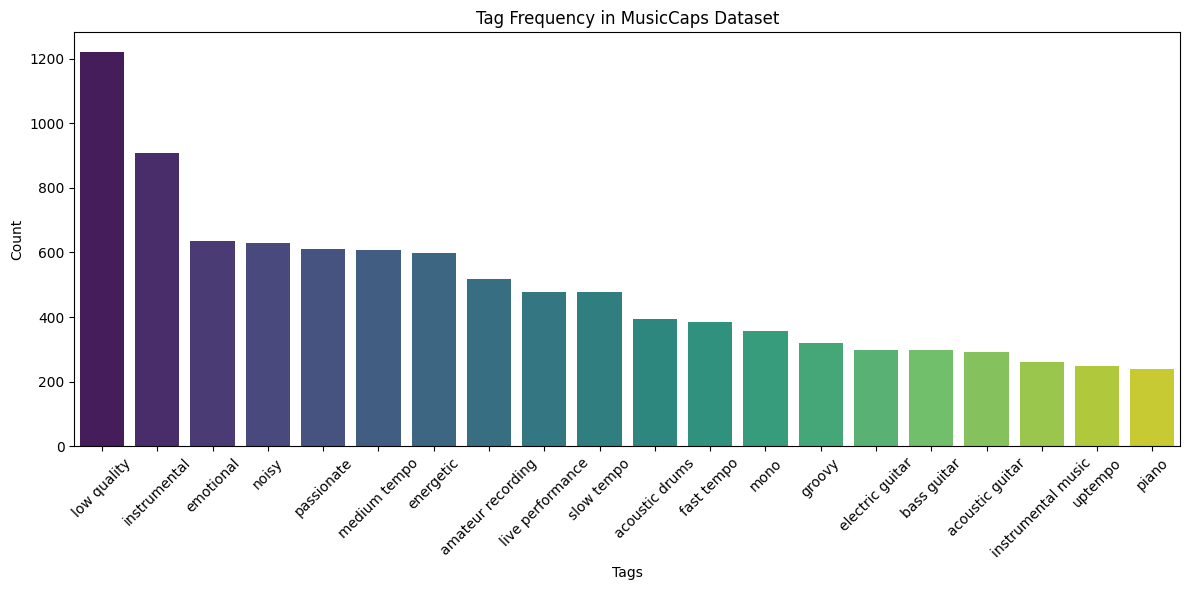

In [6]:
_tag_counts_df = tag_counts_df.head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=_tag_counts_df, x='Tag', y='Count', palette='viridis')
plt.xticks(rotation=45)
plt.title('Tag Frequency in MusicCaps Dataset')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [7]:
tag_counts_df.to_csv("../data/musiccaps_tag_frequencies.csv", index=False)

## Prepare concept dataset

In [8]:
def extract_tags(song_tags, concept_tags):
    res = []
    for c_tag in concept_tags:
        for s_tag in song_tags:
            if c_tag == s_tag:
                res.append(s_tag)
    return list(set(res))

In [9]:
concepts = json.load(open("../data/concepts_to_tags.json", "r"))

for concept, tags in concepts.items():
    df_train[concept + '_tags'] = df_train['aspect_list_transformed'].apply(
        lambda x: extract_tags(x, tags)
    )

In [10]:
df_train = df_train[["caption", "aspect_list_transformed", "tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]]
df_train = df_train[(df_train['genre_tags'].map(len) > 0) & 
                    (df_train['instrument_tags'].map(len) > 0)] 
df_train["combined_tags"] = df_train["tempo_tags"] + df_train["genre_tags"] + df_train["mood_tags"] + df_train["instrument_tags"]
df_train["aspect_list"] = df_train["combined_tags"].apply(lambda x: ', '.join(x))
df_train["tempo_tags"] = df_train["tempo_tags"].apply(lambda x: ', '.join(x))
df_train["genre_tags"] = df_train["genre_tags"].apply(lambda x: ', '.join(x))
df_train["mood_tags"] = df_train["mood_tags"].apply(lambda x: ', '.join(x))
df_train["instrument_tags"] = df_train["instrument_tags"].apply(lambda x: ', '.join(x))
df_train = df_train[["caption", "aspect_list", "tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]]
df_train

,caption,aspect_list,tempo_tags,genre_tags,mood_tags,instrument_tags
6,A male singer sings this groovy melody. The so...,"medium tempo, ambient noises, keyboard accompa...",medium tempo,ambient noises,,"keyboard accompaniment, male singer, groovy ba..."
8,The Pop song features a soft female vocal sing...,"pop, passionate, emotional, sad, claps, punchy...",,pop,"passionate, emotional, sad","claps, punchy kick"
11,This folk song features a male voice singing t...,"slow tempo, folk music, male voice, violin",slow tempo,folk music,,"male voice, violin"
13,This middle eastern folk song features a male ...,"moderate tempo, folk song, male voice",moderate tempo,folk song,,male voice
15,This is an R&B/soul music piece. There is a ma...,"groovy, soul, r&b, sensual, male vocal, electr...",groovy,"soul, r&b",sensual,"male vocal, electronic drums"
...,...,...,...,...,...,...
5501,This is a dancehall music piece. There is a ma...,"reggae, chill, keyboard, male vocal",,"reggae, chill",,"keyboard, male vocal"
5503,The low quality recording features a passionat...,"chill, passionate, passionate male vocal",,chill,passionate,passionate male vocal
5507,A male vocalist sings this energetic song. The...,"rock, male vocalist",,rock,,male vocalist
5509,This dance song features a female voice singin...,"moderate tempo, dance song, happy mood, female...",moderate tempo,dance song,happy mood,"female voice, bass"


In [11]:
df_train.to_csv("../data/musiccaps_tags_to_description_dataset.csv", index=False)

## Analyse dataset

In [12]:
df_train = pd.read_csv("../data/musiccaps_tags_to_description_dataset.csv")
df_train = df_train.reset_index(drop=True)
df_train = df_train.fillna('')
df_train

,caption,aspect_list,tempo_tags,genre_tags,mood_tags,instrument_tags
0,A male singer sings this groovy melody. The so...,"medium tempo, ambient noises, keyboard accompa...",medium tempo,ambient noises,,"keyboard accompaniment, male singer, groovy ba..."
1,The Pop song features a soft female vocal sing...,"pop, passionate, emotional, sad, claps, punchy...",,pop,"passionate, emotional, sad","claps, punchy kick"
2,This folk song features a male voice singing t...,"slow tempo, folk music, male voice, violin",slow tempo,folk music,,"male voice, violin"
3,This middle eastern folk song features a male ...,"moderate tempo, folk song, male voice",moderate tempo,folk song,,male voice
4,This is an R&B/soul music piece. There is a ma...,"groovy, soul, r&b, sensual, male vocal, electr...",groovy,"soul, r&b",sensual,"male vocal, electronic drums"
...,...,...,...,...,...,...
1414,This is a dancehall music piece. There is a ma...,"reggae, chill, keyboard, male vocal",,"reggae, chill",,"keyboard, male vocal"
1415,The low quality recording features a passionat...,"chill, passionate, passionate male vocal",,chill,passionate,passionate male vocal
1416,A male vocalist sings this energetic song. The...,"rock, male vocalist",,rock,,male vocalist
1417,This dance song features a female voice singin...,"moderate tempo, dance song, happy mood, female...",moderate tempo,dance song,happy mood,"female voice, bass"


In [13]:
# Display basic statistics
tag_columns = ["tempo_tags", "genre_tags", "mood_tags", "instrument_tags", "aspect_list"]
for col in tag_columns:
    df_train[col + '_count'] = df_train[col].apply(lambda x: len(x.split(', ')))
display(df_train[[col + '_count' for col in tag_columns]].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

,tempo_tags_count,genre_tags_count,mood_tags_count,instrument_tags_count,aspect_list_count
count,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000
mean,1.186751,1.296688,1.523608,2.085976,5.279070
std,0.543918,0.654858,0.916838,1.148836,2.039021
min,1.000000,1.000000,1.000000,1.000000,2.000000
25%,1.000000,1.000000,1.000000,1.000000,4.000000
50%,1.000000,1.000000,1.000000,2.000000,5.000000
75%,1.000000,1.000000,2.000000,3.000000,7.000000
90%,2.000000,2.000000,3.000000,4.000000,8.000000
95%,2.000000,3.000000,3.000000,4.000000,9.000000
99%,4.000000,4.000000,5.000000,5.000000,11.000000


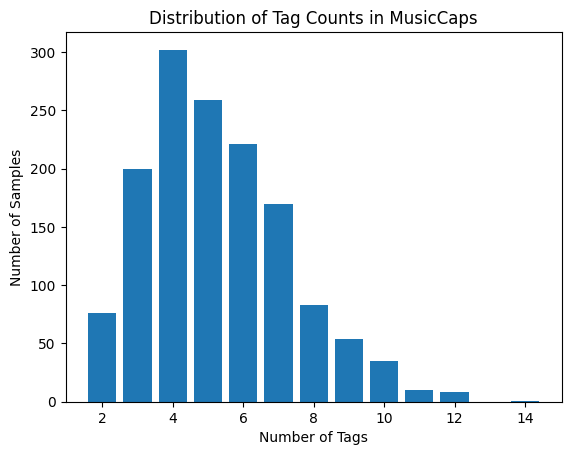

In [14]:
# calculate tag len distribution
tag_len_counts = df_train['aspect_list'].map(lambda x: len(x.split(', '))).value_counts().sort_index()
plt.bar(tag_len_counts.index, tag_len_counts.values)
plt.xlabel("Number of Tags")
plt.ylabel("Number of Samples")
plt.title("Distribution of Tag Counts in MusicCaps")
plt.show()

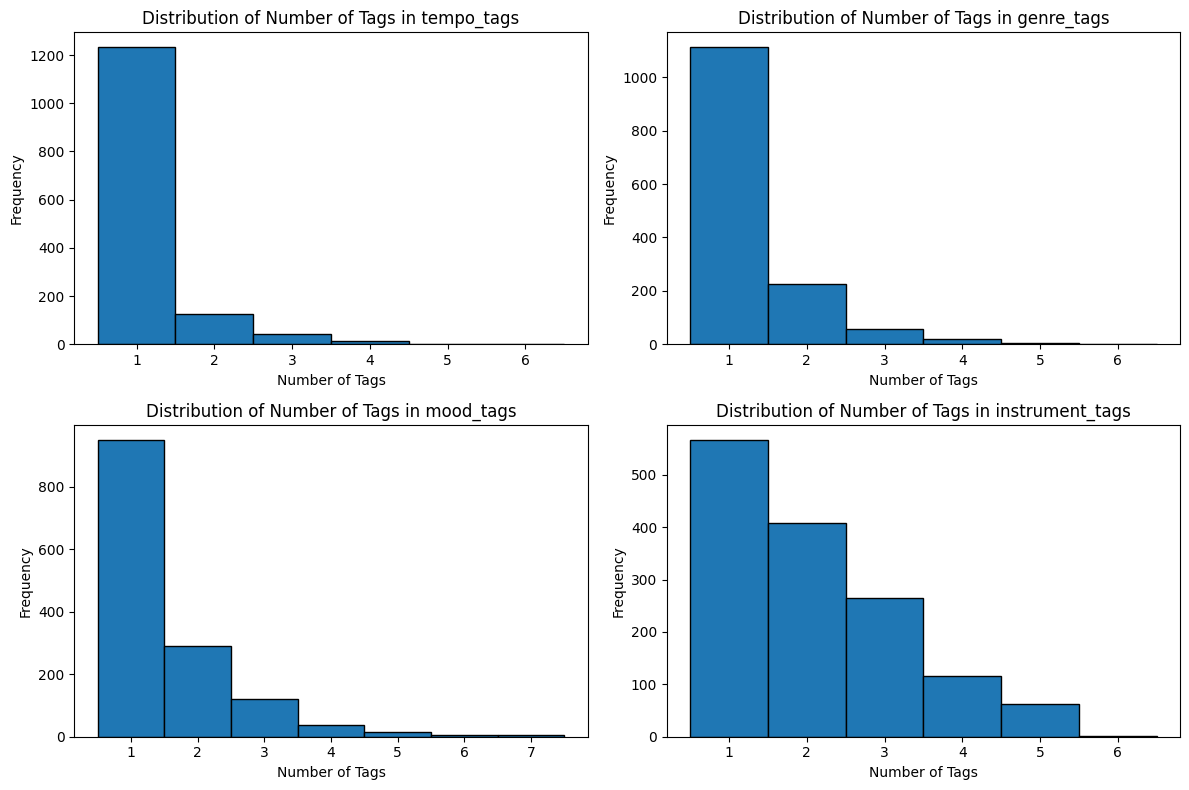

In [15]:
# Plot distribution of number of tags per category
tag_columns = ["tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]
plt.figure(figsize=(12, 8))
for i, col in enumerate(tag_columns, 1):
    plt.subplot(2, 2, i)
    tag_counts = df_train[col].apply(lambda x: len(x.split(', ')))
    
    # Create histogram with centered bin labels
    n, bins, patches = plt.hist(tag_counts, bins=range(1, tag_counts.max() + 2), edgecolor='black')
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.xticks(bin_centers, [int(x) for x in bin_centers], rotation=0)
    
    plt.title(f'Distribution of Number of Tags in {col}')
    plt.xlabel('Number of Tags')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

KS test for tempo_tags: statistic=0.5136, p-value=0.0000
KS test for genre_tags: statistic=0.4749, p-value=0.0000
KS test for mood_tags: statistic=0.4124, p-value=0.0000
KS test for instrument_tags: statistic=0.2631, p-value=0.0000


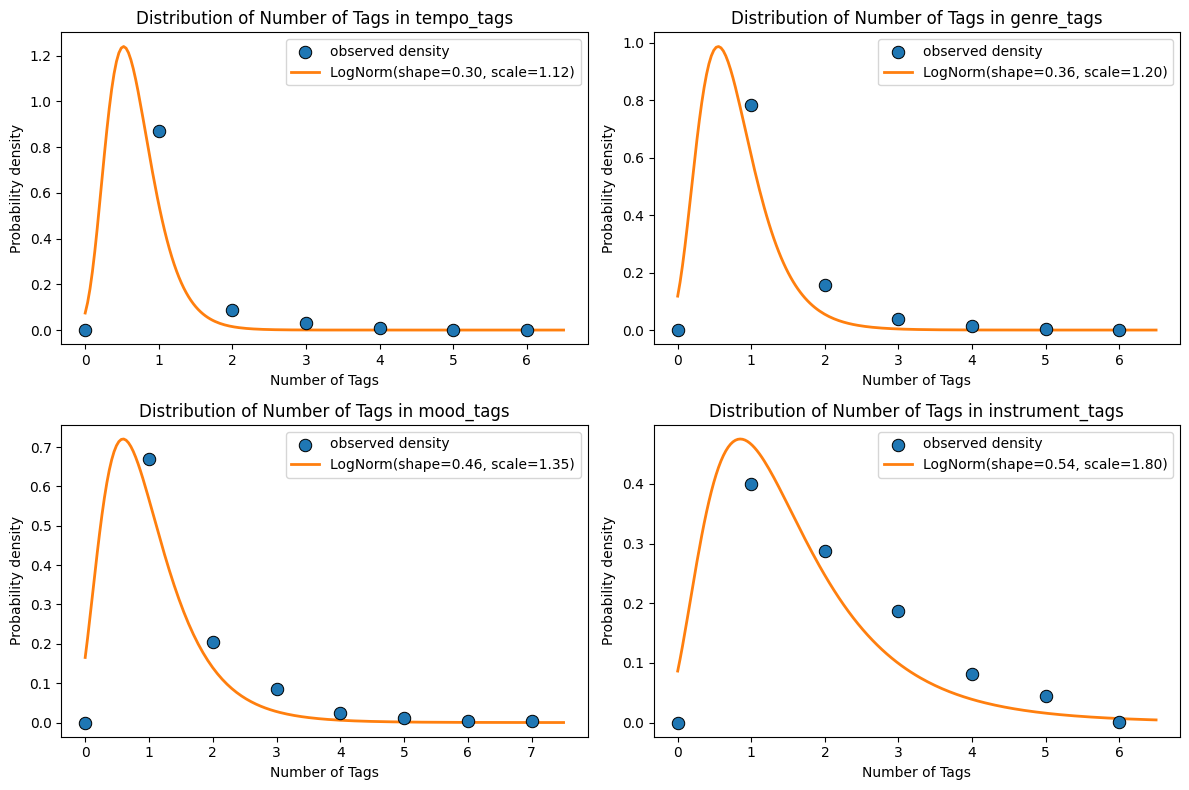

In [16]:
tag_columns = ["tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]
plt.figure(figsize=(12, 8))
for i, col in enumerate(tag_columns, 1):
    plt.subplot(2, 2, i)
    counts_series = df_train[col].apply(lambda x: len(x.split(', '))).astype(int)
    max_k = int(counts_series.max())
    bins = np.arange(0, max_k + 2)  # integer bin edges including zero
    counts, edges = np.histogram(counts_series, bins=bins)
    bin_centers = (edges[:-1] + edges[1:]) / 2

    # Convert raw counts to probability density so it matches the continuous PDF
    bin_width = edges[1] - edges[0]
    counts_density = counts / (counts_series.size * bin_width)

    # Plot observed density as points
    sns.scatterplot(x=bin_centers, y=counts_density, color='C0', s=80, edgecolor='k', zorder=3, label='observed density')

    # Fit log-normal to positive counts (exclude zeros for log fit)
    positive = counts_series[counts_series > 0]
    # fit with loc fixed to 0 to model pure log-normal on positive support
    shape, loc, scale = stats.lognorm.fit(positive, floc=0)
    x = np.linspace(0.5, float(max_k) + 1.0, 200)  # avoid zero for logpdf
    pdf = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)

    # Overlay PDF (no extra scaling needed since counts_density is a density)
    plt.plot(x, pdf, color='C1', lw=2, label=f'LogNorm(shape={shape:.2f}, scale={scale:.2f})')

    # KS test against lognormal (on positive data)
    ks = stats.kstest(positive, 'lognorm', args=(shape, loc, scale))
    print(f'KS test for {col}: statistic={ks.statistic:.4f}, p-value={ks.pvalue:.4f}')

    # Set x-axis ticks at bin centers for better readability
    plt.xticks(bin_centers, [int(x) for x in bin_centers], rotation=0)
    
    plt.title(f'Distribution of Number of Tags in {col}')
    plt.xlabel('Number of Tags')
    plt.ylabel('Probability density')
    plt.legend()

plt.tight_layout()
plt.show()

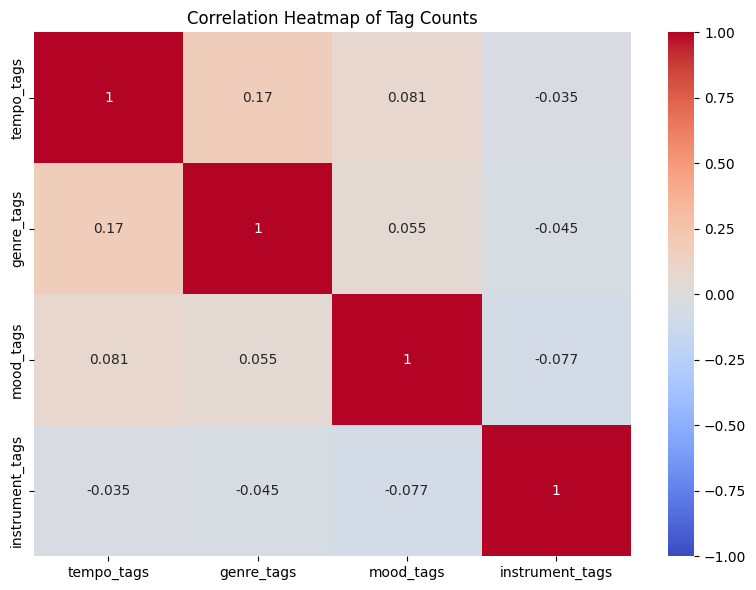

In [17]:
# Correlation heatmap of tag counts
tag_count_data = {}
for col in tag_columns:
    tag_count_data[col] = df_train[col].apply(lambda x: len(x.split(', ')))
tag_count_df = pd.DataFrame(tag_count_data)
plt.figure(figsize=(8, 6))
sns.heatmap(tag_count_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Tag Counts')
plt.tight_layout()
plt.show()

## Save final dataset

In [18]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df_train, test_size=0.1, random_state=42)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=42)

In [19]:
# Create output directory
output_dir = Path("../data/tags")
output_dir.mkdir(parents=True, exist_ok=True)

df_train.to_csv(output_dir / "train.csv", index=False)
df_valid.to_csv(output_dir / "validation.csv", index=False)
df_test.to_csv(output_dir / "test.csv", index=False)
all_df = pd.concat([df_train, df_valid, df_test])
all_df.to_csv(output_dir / "all.csv", index=False)

In [20]:
data_files = {
    "train": str(output_dir / "train.csv"),
    "validation": str(output_dir / "validation.csv"),
    "test": str(output_dir / "test.csv")
}
dataset = load_dataset("csv", data_files=data_files)
dataset.push_to_hub("bsienkiewicz/musiccaps-tags-to-caption", private=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/907 [00:00<?, ?B/s]

C:\Users\bruno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\bruno\.cache\huggingface\hub\datasets--bsienkiewicz--musiccaps-tags-to-caption. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CommitInfo(commit_url='https://huggingface.co/datasets/bsienkiewicz/musiccaps-tags-to-caption/commit/53be5daa5cd45158fdcbd8b80f49a4c884ac4393', commit_message='Upload dataset', commit_description='', oid='53be5daa5cd45158fdcbd8b80f49a4c884ac4393', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/bsienkiewicz/musiccaps-tags-to-caption', endpoint='https://huggingface.co', repo_type='dataset', repo_id='bsienkiewicz/musiccaps-tags-to-caption'), pr_revision=None, pr_num=None)